In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "48"
os.environ["OPENBLAS_NUM_THREADS"] = "48"
os.environ["MKL_NUM_THREADS"] = "48"

In [2]:
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np
from scipy.optimize import minimize, dual_annealing
from scipy.linalg import expm
import matplotlib.pyplot as plt
from utils import encoding, derivative_matrix

In [2]:
from qiskit import *
from qiskit_aer import AerSimulator

In [4]:
H = np.load("wave_hamiltonian.npy")

In [5]:
eigvals, eigvecs = np.linalg.eigh(H)

In [10]:
def analytic_solution(x, y, t):
    omega = np.pi / np.sqrt(2)
    return np.sin(np.pi * (x + 1) / 2) * np.sin(np.pi * (y + 1) / 2) * np.cos(omega * t)

In [6]:
def initial_conditions(x, y):
    return np.sin(np.pi * (x + 1) / 2) * np.sin(np.pi * (y + 1) / 2)

In [7]:
def get_2d_cheb_coeffs(func, deg):
    nodes = np.cos(np.pi * (np.arange(deg + 1) + 0.5) / (deg + 1))
    X, Y = np.meshgrid(nodes, nodes, indexing='ij')
    F_vals = func(X, Y)

    coeffs_y = np.polynomial.chebyshev.chebfit(nodes, F_vals.T, deg).T
    coeffs = np.polynomial.chebyshev.chebfit(nodes, coeffs_y, deg)
    weights = np.array([derivative_matrix.get_weight(k, deg) for k in range(deg+1)])

    W_x = weights[:, np.newaxis]
    W_y = weights[np.newaxis, :]
    target_coeffs = coeffs / (W_x * W_y)
    return target_coeffs.flatten()

def compute_solution(psi, deg):
    tau_start = encoding.chebyshev_encoding(deg, -1.0)
    psi_tensor = psi.reshape((deg+1, (deg+1)**2))
    psi_t_start = tau_start @ psi_tensor
    f_coeffs = get_2d_cheb_coeffs(initial_conditions, deg)
    projection = np.dot(psi_t_start, f_coeffs)
    norm_psi_t = np.dot(f_coeffs, f_coeffs)
        
    if abs(projection) > 1e-12:
        scale = norm_psi_t / projection
        psi *= scale
    return psi

In [8]:
def compute_relative_L2(psi):
    t_vals, x_vals, y_vals = (np.linspace(-1,1,10), np.linspace(-1,1,10), np.linspace(-1,1,10))
    T_end = 3.0
    deg = 2**4 - 1
    psi_sol = compute_solution(psi, deg)
    wave_solution = np.zeros((len(t_vals), len(x_vals), len(y_vals)))
    for ti, t in enumerate(t_vals):
        for xi, x in enumerate(x_vals):
            for yi, y in enumerate(y_vals):
                tau_x = encoding.chebyshev_encoding(deg, x)
                tau_y = encoding.chebyshev_encoding(deg, y)
                tau_t = encoding.chebyshev_encoding(deg, t)
                tau_txy = np.kron(tau_t, np.kron(tau_x, tau_y))
                w_val = np.dot(tau_txy, psi_sol)
                wave_solution[ti, xi, yi] = w_val

    t_vals_original = (t_vals + 1) * (T_end / 2)
    true_solution = np.zeros((len(t_vals), len(x_vals), len(y_vals)))
    for ti, t in enumerate(t_vals_original):
        for xi, x in enumerate(x_vals):
            for yi, y in enumerate(y_vals):
                true_solution[ti, xi, yi] = analytic_solution(x, y, t)
    error = wave_solution - true_solution
    return np.linalg.norm(error) / np.linalg.norm(true_solution)

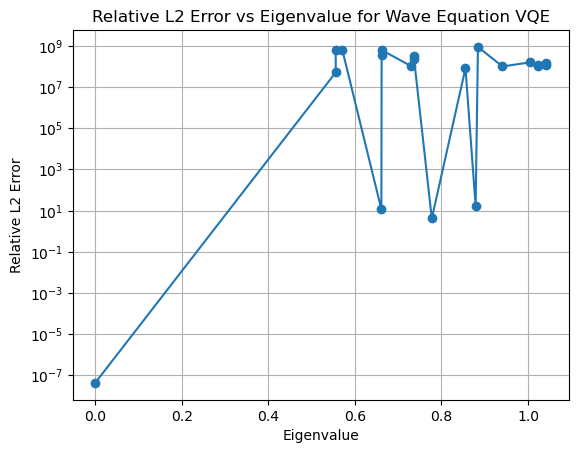

In [11]:
eigenvalue_list = eigvals[:20]
relative_L2_list = [compute_relative_L2(eigvecs[:, i]) for i in range(20)]
plt.plot(eigenvalue_list, relative_L2_list, 'o-')
plt.yscale('log')
plt.xlabel('Eigenvalue')
plt.ylabel('Relative L2 Error')
plt.title('Relative L2 Error vs Eigenvalue for Wave Equation VQE')
plt.grid()
plt.show()

In [12]:
print("Relative L2 errors for first 5 eigenvectors:")
for i in range(5):
    print(f"Eigenvalue: {eigvals[i]:.6f}\tRelative L2 Error: {relative_L2_list[i]:.6e}")

Relative L2 errors for first 5 eigenvectors:
Eigenvalue: 0.000000	Relative L2 Error: 4.316077e-08
Eigenvalue: 0.555789	Relative L2 Error: 5.191452e+07
Eigenvalue: 0.555789	Relative L2 Error: 6.620636e+08
Eigenvalue: 0.571339	Relative L2 Error: 6.058171e+08
Eigenvalue: 0.661215	Relative L2 Error: 1.160908e+01


In [13]:
def variational_ansatz(params, n_qubits):
    layers = len(params) // n_qubits
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    for l in range(layers):
        for i in range(n_qubits):
            qml.RY(params[l*n_qubits + i], i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

In [33]:
H_new = H / np.linalg.norm(H, ord=2)
eigvals, eigvecs = np.linalg.eigh(H_new)
U_diag = np.exp(-1j * eigvals)
U1 = eigvecs @ np.diag(U_diag) @ eigvecs.conj().T

In [11]:
def variational_ansatz(params, n_qubits, U=U_mat):
    layers = len(params)
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    for l in range(layers):
        qml.QubitUnitary(pnp.exp(params[l]) * U, wires=range(n_qubits))
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1]) 

In [50]:
U_mat_qiskit = np.array(U1)
sim = AerSimulator(method='statevector')
sim.set_options = {"max_parallel_threads" : 48}

def variational_ansatz(circuit, params, n_qubits, U=U_mat_qiskit):
    layers = len(params) 
    for i in range(n_qubits):
        circuit.h(i)
    for l in range(layers):
        circuit.unitary(np.exp(1j * params[l]) * U, range(n_qubits))
        for i in range(n_qubits - 1):
            circuit.cx(i, i + 1)

def vqe_circuit(params, n_qubits=int(np.log2(H.shape[0])), sim=sim, Hamiltonian=H):
    circuit = QuantumCircuit(n_qubits)
    variational_ansatz(circuit, params, n_qubits)
    circuit.save_statevector()
    result = sim.run(circuit).result()
    psi = np.asarray(result.get_statevector(circuit), dtype=np.complex128)
    energy = np.vdot(psi, Hamiltonian @ psi).real
    return energy

In [53]:
def cost_function(x):
    global iteration
    cost_val = vqe_circuit(x)
    print(f"Iteration {iteration}: Cost = {cost_val}")
    iteration += 1
    return cost_val

iteration = 1
layers = 6
params = np.random.uniform(-2*np.pi, 2*np.pi, size=(layers,))
max_iter = 100
res = minimize(cost_function, params, method="COBYLA", options={"maxiter": max_iter})

Iteration 1: Cost = 198904054.71874034
Iteration 2: Cost = 198904054.7187403
Iteration 3: Cost = 198904054.71874022
Iteration 4: Cost = 198904054.71874025
Iteration 5: Cost = 198904054.71874022
Iteration 6: Cost = 198904054.71874022
Iteration 7: Cost = 198904054.71874017
Iteration 8: Cost = 198904054.71874028
Iteration 9: Cost = 198904054.71874028
Iteration 10: Cost = 198904054.7187402
Iteration 11: Cost = 198904054.71874028
Iteration 12: Cost = 198904054.7187402
Iteration 13: Cost = 198904054.7187403
Iteration 14: Cost = 198904054.71874025
Iteration 15: Cost = 198904054.71874025
Iteration 16: Cost = 198904054.7187403
Iteration 17: Cost = 198904054.71874025
Iteration 18: Cost = 198904054.71874037
Iteration 19: Cost = 198904054.71874017
Iteration 20: Cost = 198904054.71874022
Iteration 21: Cost = 198904054.71874025
Iteration 22: Cost = 198904054.71874028
Iteration 23: Cost = 198904054.71874022
Iteration 24: Cost = 198904054.7187404
Iteration 25: Cost = 198904054.71874022
Iteration 26: C

In [57]:
circ = QuantumCircuit(12)
variational_ansatz(circ, res.x, 12)
circ.save_statevector()
result = sim.run(circ).result()
psi = np.asarray(result.get_statevector(circ), dtype=np.complex128)
rel_L2_error = compute_relative_L2(psi)
print(f"Relative L2 Error of the obtained state: {rel_L2_error}")

Relative L2 Error of the obtained state: 3397.856243786048


/tmp/ipykernel_124349/2674739883.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  wave_solution[ti, xi, yi] = w_val


In [14]:
dev = qml.device("lightning.qubit", wires=12)

@qml.qnode(dev)
def vqe_circuit(params):
    variational_ansatz(params, n_qubits=12)
    return qml.expval(qml.Hermitian(H, wires=range(12)))

In [15]:
@qml.qnode(dev)
def compute_psi(params):
    variational_ansatz(params, n_qubits=12)
    return qml.state()

In [14]:
def gradient(x):
    x_pnp = pnp.array(x, requires_grad=True)
    grad_val = qml.grad(vqe_circuit)(x_pnp)
    return np.array(grad_val)

In [17]:
def cost_function(x):
    global iteration
    cost_val = vqe_circuit(x)
    print(f"Iteration {iteration}: Cost = {cost_val}")
    iteration += 1
    return cost_val

iteration = 1
layers = 1
params = np.random.uniform(-2*np.pi, 2*np.pi, size=(layers * 12,))
max_iter = 2000
res = minimize(cost_function, params, method="COBYLA", options={"maxiter": max_iter})

Iteration 1: Cost = 149788937.95007017
Iteration 2: Cost = 140437942.0052529
Iteration 3: Cost = 129337593.36854127
Iteration 4: Cost = 117573008.6353209
Iteration 5: Cost = 125303987.88496126
Iteration 6: Cost = 116073954.97034602
Iteration 7: Cost = 99050109.02761044
Iteration 8: Cost = 82742979.47830132
Iteration 9: Cost = 83101861.84961036
Iteration 10: Cost = 89486829.6327465
Iteration 11: Cost = 102639078.90123217
Iteration 12: Cost = 80841895.80430603
Iteration 13: Cost = 59342450.3860556
Iteration 14: Cost = 27058972.25875462
Iteration 15: Cost = 11154191.099078508
Iteration 16: Cost = 7422823.397001148
Iteration 17: Cost = 13506051.711272886
Iteration 18: Cost = 5515783.121673124
Iteration 19: Cost = 8669751.37974112
Iteration 20: Cost = 5793176.719953235
Iteration 21: Cost = 6904200.889392989
Iteration 22: Cost = 12809880.28978507
Iteration 23: Cost = 5527629.648666227
Iteration 24: Cost = 11572919.44638846
Iteration 25: Cost = 7465590.429527929
Iteration 26: Cost = 4167390.1

In [30]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_qubits = 12
pnp.random.seed(42)
layers = 3
params = pnp.random.uniform(-2*np.pi, 2*np.pi, size=(layers * n_qubits,), requires_grad=True)
max_iter = 5000

for it in range(max_iter):
    params, cost_val = opt.step_and_cost(vqe_circuit, params)
    print(f"Iteration {it+1}/{max_iter}, Cost: {cost_val:.6f}")

Iteration 1/5000, Cost: 122015639.307534
Iteration 2/5000, Cost: 117852974.731320
Iteration 3/5000, Cost: 113765873.748255
Iteration 4/5000, Cost: 109764565.199324
Iteration 5/5000, Cost: 105855409.900551
Iteration 6/5000, Cost: 102042243.271677
Iteration 7/5000, Cost: 98329807.126428
Iteration 8/5000, Cost: 94723131.631451
Iteration 9/5000, Cost: 91226150.342339
Iteration 10/5000, Cost: 87841431.837381
Iteration 11/5000, Cost: 84570513.325352
Iteration 12/5000, Cost: 81414200.369023
Iteration 13/5000, Cost: 78372563.446140
Iteration 14/5000, Cost: 75444787.172073
Iteration 15/5000, Cost: 72629066.422310
Iteration 16/5000, Cost: 69922610.360996
Iteration 17/5000, Cost: 67321743.096913
Iteration 18/5000, Cost: 64822076.072862
Iteration 19/5000, Cost: 62418727.855127
Iteration 20/5000, Cost: 60106565.190347
Iteration 21/5000, Cost: 57880436.558684
Iteration 22/5000, Cost: 55735372.363760
Iteration 23/5000, Cost: 53666736.321558
Iteration 24/5000, Cost: 51670325.455817
Iteration 25/5000, 

In [31]:
# psi = compute_psi(res.x)
psi = compute_psi(params)
print("Relative L2 Error of VQE Solution:", compute_relative_L2(psi.real))
print("Relative L2 Error from Classical Solution:", compute_relative_L2(eigvecs[:, 0]))

Relative L2 Error of VQE Solution: 10.1827743439756
Relative L2 Error from Classical Solution: 4.316076660261543e-08


In [23]:
print("Max imaginary part of VQE psi:", np.max(np.abs(psi.imag)))

Max imaginary part of VQE psi: 0.0


In [29]:
8 * 4 * 10**18 / 1024 / 1024 / 1024 / 1024 / 1024

28421.709430404007